In [23]:
#!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install opencage==1.1.0
#!pip install geocoder
#!pip install descartes
#!pip install geopandas
#!conda install basemap --yes
#!pip install scipy
#!pip install --upgrade pip
#!pip install pillow

    100% |████████████████████████████████| 2.0MB 7.4MB/s eta 0:00:01   23% |███████▌                        | 460kB 5.6MB/s eta 0:00:01


In [24]:
import pandas as pd
import urllib.request
import requests
import csv
import numpy as np
from geopy.geocoders import Nominatim
import geocoder as gc
import PIL
from PIL import Image
import geopandas as gpd
from mpl_toolkits.basemap import Basemap, addcyclic
from scipy.ndimage.filters import minimum_filter, maximum_filter
#from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
NJ=pd.read_csv("NJ_DATA_1.csv",index_col=None)
NJ.columns = NJ.columns.str.replace(' ', '_')
NJ.rename(columns={'2015_Population':'Pop_2015', '2045_Population':'Pop_2045', 'Annualized_%_Population_Change_2015-2045':'Pop_Change', '2015_Households':'House_2015', '2045_Households':'House_2045', 'Annualized_%_Household_Change_2015-2045':'House_Change', '2015_Employment':'Employ_2015', '2045_Employment':'Employ_2045', 'Annualized_%_Employment_Change_2015-2045':'Employ_Change'}, inplace=True)
NJ["Pop_2015"] = NJ["Pop_2015"].str.replace(",","").astype(float)
NJ["Pop_2045"] = NJ["Pop_2045"].str.replace(",","").astype(float)
NJ["House_2015"] = NJ["House_2015"].str.replace(",","").astype(float)
NJ["House_2045"] = NJ["House_2045"].str.replace(",","").astype(float)
NJ["Employ_2015"] = NJ["Employ_2015"].str.replace(",","").astype(float)
NJ["Employ_2045"] = NJ["Employ_2045"].str.replace(",","").astype(float)
#NJ["Pop_Change"] = NJ["Pop_Change"].str.replace("%","").astype(float)/100 
#NJ["House_Change"] = NJ["House_Change"].str.replace("%","").astype(float)/100 
#NJ["Employ_Change"] = NJ["Employ_Change"].str.replace("%","").astype(float)/100 
NJ['Employ_Change']=NJ['Employ_2045']/NJ['Employ_2015']-1
NJ['Pop_Change']=NJ['Pop_2045']/NJ['Pop_2015']-1
NJ['House_Change']=NJ['House_2045']/NJ['House_2015']-1
NJ.head()

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
0,Bergen,3.400301e+09,Allendale borough,6674.0,7335.0,0.099041,2262.0,2483.0,0.097701,2836.0,3064.0,0.080395
1,Bergen,3.400301e+09,Alpine borough,1849.0,1849.0,0.000000,611.0,611.0,0.000000,415.0,415.0,0.000000
2,Bergen,3.400305e+09,Bergenfield borough,27181.0,29602.0,0.089070,8890.0,9682.0,0.089089,4025.0,4694.0,0.166211
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256
4,Bergen,3.400310e+09,Carlstadt borough,6224.0,6833.0,0.097847,2384.0,2607.0,0.093540,12855.0,13455.0,0.046674


In [7]:
gdf=gpd.read_file('Shape/NJTPA_Traffic_Analysis_Zones_2010.shp')

In [8]:
gdf.head()

,OBJECTID,TAZ2008,FIRST_COUN,FIRST_Muni,FIRST_Mu_1,SUM_Pop201,SUM_Hous20,SUM_OccH20,SUM_VacH20,SUM_Emp201,Shapearea,Shapelen,geometry
0,1,26,003,700,Allendale borough,6505,2388,2236,152,2868.997195,0.000865,0.143559,"POLYGON ((-74.114554503581 41.04363931711192, ..."
1,2,27,003,1090,Alpine borough,1849,670,611,59,432.562691,0.001777,0.231863,POLYGON ((-73.92718243570442 40.91750629918602...
2,3,28,003,53430,Northvale borough,3824,1312,1283,29,1277.568880,0.000212,0.069238,POLYGON ((-73.94515460729468 41.01637418171505...
3,4,29,003,64170,Rockleigh borough,1347,409,356,53,4313.555389,0.000418,0.085998,POLYGON ((-73.92208143948106 41.00590531658643...
4,5,30,003,53610,Norwood borough,5711,2007,1927,80,1921.383114,0.000758,0.140368,"POLYGON ((-73.95186144869049 41.0002073144278,..."


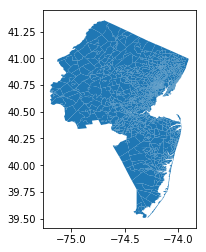

In [9]:
gdf.plot()

In [10]:
from matplotlib.colors import LinearSegmentedColormap
def plot_on_map(gdf,Y):
    gdf['Y']=float('nan') #add a column for colors to visualize
    for i in gdf.index:
        if gdf.FIRST_Mu_1[i] in Y.keys(): #if the code of the mesoregion shape has the data corresponding to it
            gdf['Y'][i]=1.0*Y[gdf.FIRST_Mu_1[i]]/max(Y.values()) #set a color corresponding to the quantity
    ax=gdf.dropna().plot(column='Y',cmap = 'cool')
    return gdf

In [11]:
#pop = NJ[['Municipality_Name', 'Pop_Change']].copy()
#pop = pop.to_dict()
#pop_keys = NJ['Municipality_Name'].copy()
#pop_values = NJ['Pop_Change'].copy()
#dictionary = dict(zip(pop_keys, pop_values))
#dictionary.keys
MN=NJ.Municipality_Name.unique(); 
PNames={r['Municipality_Name']:r['Pop_Change'] for i,r in NJ.iterrows()}
ENames={r['Municipality_Name']:r['Employ_Change'] for i,r in NJ.iterrows()}
P15Names={r['Municipality_Name']:r['Pop_2015'] for i,r in NJ.iterrows()}
PBergen={r['Municipality_Name']:r['Pop_Change'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
EBergen={r['Municipality_Name']:r['Employ_Change'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
P15Bergen={r['Municipality_Name']:r['Pop_2015'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
E15Bergen={r['Municipality_Name']:r['Employ_2015'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
#PBergen = {}
#for p in P:
#    df=NJ[NJ.County=='Bergen']
#    PBergen[[PNames[p]]]=NJ.Pop_Change[NJ.County=='Bergen'].mean()
#NJ.County=='Bergen'{r['Municipality_Name']:r['Pop_Change'] for i,r in NJ.iterrows()}


/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


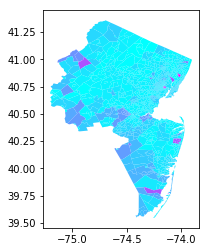

<Figure size 2880x1440 with 0 Axes>

In [15]:
plot_on_map(gdf,ENames);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


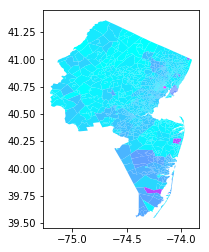

In [9]:
plot_on_map(gdf,PNames);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


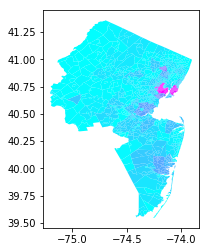

<Figure size 2880x1440 with 0 Axes>

In [17]:
plot_on_map(gdf,P15Names);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


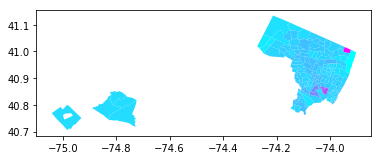

<Figure size 2880x1440 with 0 Axes>

In [25]:
plot_on_map(gdf,PBergen);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


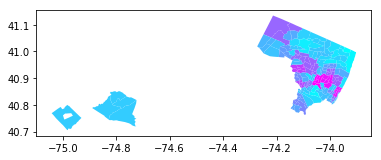

<Figure size 2880x1440 with 0 Axes>

In [29]:
plot_on_map(gdf,P15Bergen);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


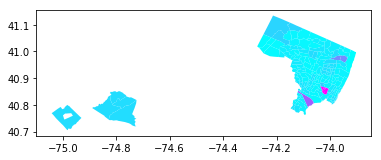

<Figure size 2880x1440 with 0 Axes>

In [30]:
plot_on_map(gdf,EBergen);

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


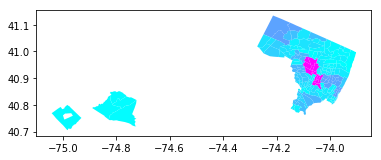

<Figure size 2880x1440 with 0 Axes>

In [32]:
plot_on_map(gdf,E15Bergen);

In [12]:
#clust = NJ[County=='Bergen'].groupby(['County','Municipality_Name'], as_index=False)['Pop_Change'].sum()
PopDF = NJ[(NJ.County=='Bergen')].sort_values(['Pop_Change'], ascending=[False]).groupby('Municipality_Name').head(5)
PopDF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
54,Bergen,3.400364e+09,Rockleigh borough,548.0,856.0,0.562044,76.0,138.0,0.815789,1622.0,1716.0,0.057953
49,Bergen,3.400363e+09,Ridgefield Park village,12946.0,17960.0,0.387301,4869.0,7714.0,0.584309,3919.0,10210.0,1.605256
58,Bergen,3.400369e+09,South Hackensack township,2493.0,3120.0,0.251504,869.0,1143.0,0.315305,6346.0,6691.0,0.054365
36,Bergen,3.400348e+09,Moonachie borough,2776.0,3247.0,0.169669,1016.0,1183.0,0.164370,5614.0,5903.0,0.051478
68,Bergen,3.400383e+09,Wood-Ridge borough,9339.0,10884.0,0.165435,3459.0,4630.0,0.338537,1919.0,2241.0,0.167796


In [13]:
EmployDF = NJ[(NJ.County=='Bergen')].sort_values(['Employ_Change'], ascending=[False]).groupby('Municipality_Name').head(5)
EmployDF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
49,Bergen,3.400363e+09,Ridgefield Park village,12946.0,17960.0,0.387301,4869.0,7714.0,0.584309,3919.0,10210.0,1.605256
10,Bergen,3.400320e+09,East Rutherford borough,9105.0,9626.0,0.057221,3822.0,4065.0,0.063579,11991.0,24173.0,1.015929
6,Bergen,3.400314e+09,Closter borough,8533.0,9040.0,0.059416,2762.0,2943.0,0.065532,3020.0,5249.0,0.738079
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256
32,Bergen,3.400343e+09,Mahwah township,26358.0,28193.0,0.069618,9547.0,10320.0,0.080968,15587.0,19698.0,0.263745


In [14]:
Pop15DF = NJ[(NJ.County=='Bergen')].sort_values(['Pop_2015'], ascending=[False]).groupby('Municipality_Name').head(5)
Pop15DF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
22,Bergen,3.400329e+09,Hackensack city,43768.0,50013.0,0.142684,18222.0,21288.0,0.168258,42488.0,45032.0,0.059876
59,Bergen,3.400372e+09,Teaneck township,40492.0,44834.0,0.107231,13533.0,15313.0,0.131530,15533.0,16741.0,0.077770
18,Bergen,3.400324e+09,Fort Lee borough,39521.0,43747.0,0.106930,17752.0,20099.0,0.132210,15545.0,16820.0,0.082020
16,Bergen,3.400322e+09,Fair Lawn borough,33524.0,36933.0,0.101688,12115.0,13424.0,0.108048,12344.0,13447.0,0.089355
20,Bergen,3.400326e+09,Garfield city,31258.0,34888.0,0.116130,11206.0,12641.0,0.128056,5942.0,6943.0,0.168462


In [15]:
Employ15DF = NJ[(NJ.County=='Bergen')].sort_values(['Employ_2015'], ascending=[False]).groupby('Municipality_Name').head(5)
Employ15DF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
22,Bergen,3.400329e+09,Hackensack city,43768.0,50013.0,0.142684,18222.0,21288.0,0.168258,42488.0,45032.0,0.059876
45,Bergen,3.400356e+09,Paramus borough,26956.0,30664.0,0.137558,8710.0,10047.0,0.153502,42332.0,44441.0,0.049820
32,Bergen,3.400343e+09,Mahwah township,26358.0,28193.0,0.069618,9547.0,10320.0,0.080968,15587.0,19698.0,0.263745
18,Bergen,3.400324e+09,Fort Lee borough,39521.0,43747.0,0.106930,17752.0,20099.0,0.132210,15545.0,16820.0,0.082020
59,Bergen,3.400372e+09,Teaneck township,40492.0,44834.0,0.107231,13533.0,15313.0,0.131530,15533.0,16741.0,0.077770


In [16]:
T5E15Bergen={r['Municipality_Name']:r['Employ_2015'] for i,r in NJ[NJ.Municipality_Name==('Hackensack city')].iterrows()}
T5E15Bergen

{'Hackensack city': 42488.0}

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


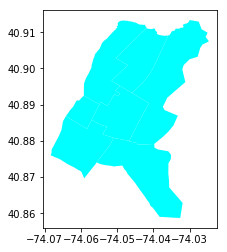

<Figure size 2880x1440 with 0 Axes>

ZeroDivisionError: float division by zero

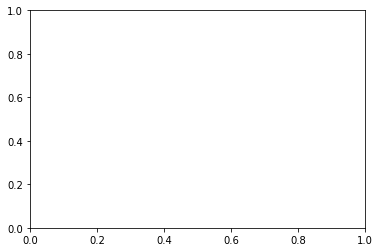